<a href="https://colab.research.google.com/github/ZinoorFatima/Automated-Glaucoma-Detection/blob/main/DIP_Project_updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#importing libraries
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage import color
from skimage.feature import canny
from skimage.morphology import dilation
from google.colab import drive
from tensorflow.keras.models import load_model

In [3]:
#load google drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Optic Disk Segmentation**

Defining Blocks for CNN

In [23]:
#double convolution block
"""
Function Name: double_conv
Purpose: A function to apply two convolutional layers in sequence to the
        input tensor with ReLU activation function.
Parameters: tensor => the input tensor
            numfilters => The number of filters in each convolutional layer
Return Values: tensor => updated tesnor after applying 2 convolutional layers
"""
def double_conv(tensor, numfilters):
    #Conv2D layer 1 with ReLU activation and kernel size 3x3 and kernel is
    #intialized using He normal intialization
    tensor = tf.keras.layers.Conv2D(numfilters, 3, padding="same", activation="relu",
                                    kernel_initializer="he_normal")(tensor)

    #Conv2D layer 2 with ReLU activation and kernel size 3x3 and kernel is
    #intialized using He normal intialization
    tensor = tf.keras.layers.Conv2D(numfilters, 3, padding="same", activation="relu",
                                    kernel_initializer="he_normal")(tensor)
    return tensor


In [24]:
#downsample block
"""
Function Name: downsample
Purpose: A function to reduce the spatial dimensions of the input tensor using
        using max pooling layer and applies dropout layer to avoid overfitting
Parameters: tensor => the input tensor
            numfilters => The number of filters in each convolutional layer
Return Values: output_tensor => The output of the double convolutional layers
                                that has the extracted features
              pooling_output => The pooled features from the max pooling and
                                dropout layer
"""
def downsample(tensor, numfilters):
    output_tensor = double_conv(tensor, numfilters)
    pooling_output = tf.keras.layers.MaxPool2D(2)(output_tensor)
    pooling_output = tf.keras.layers.Dropout(0.3)(pooling_output)
    return output_tensor, pooling_output

In [25]:
#upsample block
"""
Function Name: upsample
Purpose: A function to increase the spatial dimensions of the input tensor using
        transposed convoltion, concatenating tensor with convfeatures, applying
        dropout and double convolution
Parameters: tensor => the input tensor
            convfeatures => The features extracted from downsampling
            numfilters => The number of filters in each convolutional layer
Return Values: tensor => updated tesnor after applying upsampling
"""
def upsample(tensor, convfeatures, numfilters):
    #deconvolution to increase spatial dimensions of the input
    tensor = tf.keras.layers.Conv2DTranspose(numfilters, 3, 2, padding="same")(tensor)

    #concatenate the upsampled tensor with the downsampled features
    tensor = tf.keras.layers.concatenate([tensor, convfeatures])

    #dropout layer to reduce overfitting
    tensor = tf.keras.layers.Dropout(0.3)(tensor)

    #double convolutional block
    tensor = double_conv(tensor, numfilters)
    return tensor

U-Net Model for Optic Disk Segmentation

In [26]:
"""
Function Name: create_od_segmentation_model
Purpose: A function to create a unet model to segment the optic disk from
          retinal fungus images.
Parameters: None
Return Values: od_model => unet model for optic disk segmentation
"""
def create_od_segmentation_model():
    #Input Layer => RGB Images of size 128 x 128 pixels
    input = tf.keras.layers.Input(shape=(128,128,3))

    #Encoder => 4 downsampling blocks to reduce spatial dimensions and enhance feature extraction

    #downsample block 1 extracting 32 features
    features1, pooled1 = downsample(input, 32)
    #downsample block 2 extracting 64 features
    features2, pooled2 = downsample(pooled1, 64)
    #downsample block 3 extracting 128 features
    features3, pooled3 = downsample(pooled2, 128)
    #downsample block 4 extracting 256 features
    features4, pooled4 = downsample(pooled3, 256)


    #Bottleneck => The bottom layer of unet with most compressed representation of the input image with 256 filters
    bottleneck = double_conv(pooled4, 256)

    #Decoder => 4 upsampling blocks to restore the spatial dimensions

    #upsample block 1 increasing image size by combining with features4
    upsample6 = upsample(bottleneck, features4, 256) # 512
    #upsample block 2 increasing image size by combining with features3
    upsample7 = upsample(upsample6, features3, 128) # 256
    #upsample block 3 increasing image size by combining with features2
    upsample8 = upsample(upsample7, features2, 64) # 128
    #upsample block 4 increasing image size by combining with features1
    upsample9 = upsample(upsample8, features1, 32)

    #Output Layer => A segmentation mask of OD with same spaital dimesnion as input image
    #                Pixel values between 0 and 1 because of sigmoid activation
    outputs = tf.keras.layers.Conv2D(1, 1, padding="same", activation = "sigmoid")(upsample9)

    #Creating and returning the Unet model
    od_model = tf.keras.Model(input, outputs, name="U-Net")
    return od_model

Custom Functions for OD Segmentation Model

In [27]:
#accuracy function
"""
Function Name: accuracy
Purpose: A function to compute the dice coefficient for image
Parameters: y_true => ground truth value
            y_pred => predicted value
Return Values: dice_coef => dice coefficient for the predicted image
"""
def accuracy(y_true, y_pred):
    #reshaping the tensors to 1D vectors
    y_true_reshaped = tf.reshape(y_true, [-1])
    y_pred_reshaped = tf.reshape(y_pred, [-1])

    #calculating count of true positive pixels
    true_postive = tf.reduce_sum(y_true_reshaped * y_pred_reshaped)

    #calculating and returning dice coefficient
    dice_coef = (2. * true_postive + 1e-6) / (tf.reduce_sum(y_true_reshaped) + tf.reduce_sum(y_pred_reshaped) + 1e-6)
    return dice_coef

In [28]:
#loss function
"""
Function Name: loss
Purpose: A function to compute the loss in an image for a model
Parameters: y_true => ground truth value
            y_pred => predicted value
Return Values: loss_val => the loss value measure
"""
def loss(y_true, y_pred):
    #calculating and returning loss
    loss_val = -tf.math.log(accuracy(y_true, y_pred))
    return loss_val

In [29]:
#IoU function
"""
Function Name: iou
Purpose: A function to compute the intersection/union ratio
Parameters: y_true => ground truth value
            y_pred => predicted value
            threshold => threshold value set by default to 0.5
                         for thresholding y_pred
Return Values: iou_val => intersection to union ratio
"""
def iou(y_true, y_pred, threshold=0.5):

    #reshaping y_true into a 1D array
    y_true = tf.reshape(y_true, [-1])

    #converting datatype
    y_true = tf.cast(y_true, tf.float32)

    #thresholding y_pred using the threshold value
    y_pred = tf.cast(y_pred > threshold, tf.float32)

    #reshaping y_pred into a 1D array
    y_pred = tf.reshape(y_pred, [-1])

    #computing intersection and union
    intersection = tf.reduce_sum(y_true*y_pred)
    union = tf.reduce_sum(tf.cast(y_true + y_pred > 0, tf.float32))

    #caluclating and returning the IoU ratio
    iou_val = intersection/union
    return iou_val

Data Augmentation

In [30]:
"""
Function Name: data_augmentation
Purpose: A function to perform data augmentation on input image and mask, inorder
        to increase the variability and robutsness of training data.
Parameters: image => The input image
            mask => The corresponding mask for the image
            training => A flag to check if augmentation should be applied.
                        Defualt value True.
Return Values: image => augmented image
               mask => augmented mask
"""
def data_augmentation(image, mask, training=True):

    #copying parameters to local variables
    image = image.copy()
    mask = mask.copy()

    #augmentation applied only if training
    if training:

        #changing brightness and hue of the image
        image = tf.image.random_brightness(image, 0.1)
        image = tf.image.random_hue(image, 0.1)

        #seed for random generator
        seed = np.random.randint(0, 1000, (2, ))

        #randomly selecting whether to apply cropping with 50% probability
        if np.random.rand() < 0.5:

            #cropping the image and mask to a square of random size in range 210 to 256
            random_size = np.random.randint(210, 256)

            image = tf.image.stateless_random_crop(image, [random_size, random_size, 3], seed=seed)
            mask = tf.image.stateless_random_crop(mask, [random_size, random_size, 3], seed=seed)

        #randomly selecting whether to apply flipping with 50% probability
        if np.random.rand() < 0.5:

            #flipping image and mask vertically
            image = tf.image.stateless_random_flip_up_down(image, seed)
            mask = tf.image.stateless_random_flip_up_down(mask, seed)


    #resizing image and mask to 128 x 128 and then normalizing them in range -1, 1
    image = tf.image.resize(image, (128, 128))/122.5 - 1.0
    mask = tf.cast(tf.image.resize(mask, (128, 128)) > 122.5, float)[:, :, :1] #mask are thresholded to ensure they remain binary

    return image, mask

Load Training Data

In [31]:
#path of folder on google drive with retinal images
image_folder = '/content/drive/My Drive/ORIGA DATASET/RIGA 200 Images/'

#global variables to stores images, masks, and filenames
I, M, filenames = [], [], []

#loop to load 80 images and their masks from the input dataset
for i in range(1, 90 + 1):

    #image name is of pattern number.png
    image_name = f'{i}.png'

    #file path for image
    img_path = os.path.join(image_folder, f'{i}.png')

    #file path for mask
    mask_path = os.path.join(image_folder, f'{i}.tif')

    #reading image and resizing to 256 x 256
    image = cv2.imread(img_path)
    image = cv2.resize(image, (256, 256))

    #reading mask and resizing to 256 x 256
    mask = cv2.imread(mask_path)
    mask = cv2.resize(mask, (256, 256))

    #adding images, masks, and filenames to correct lists
    I.append(image)
    M.append(mask)
    filenames.append(image_name)

Splitting Training and Testing Data

In [32]:
#global variables

#creating a list to shuffle data for randomization
mask = list(range(len(I)))

#shuffling the mask list
np.random.seed(0)
np.random.shuffle(mask)

n_train = int(0.7*len(mask)) #number of samples for training model

#seperating training data 70% data
Image_train = [I[i] for i in mask[:n_train]]
Mask_train = [M[i] for i in mask[:n_train]]
name_train = [filenames[i] for i in mask[:n_train]]

#seperating test data 30% data
Image_test = [I[i] for i in mask[n_train:]]
Mask_test = [M[i] for i in mask[n_train:]]
name_test = [filenames[i] for i in mask[n_train:]]

In [33]:
"""
Function Name: generate_data
Purpose: A function to generate test and training data
Parameters: I=> list og images
            M => list of masks
            batch_size => Defines the batch size for data. Set to default by 4
            training => Tells if data is training data. Set to default by True
Return Values: mini_I => batch of images
               mini_M => batch of masks
"""
def generate_data(I, M, batch_size=4, training=True):
    #number of images in I
    n_data = len(I)

    i = 0 #loop variable

    #infinite loop so generator generats batches infinitely
    while True:

        #reseting index i and shuffles mask if batch number exceeds the total data points
        if i + batch_size > n_data:
            i = 0
            mask = np.arange(n_data)
            np.random.shuffle(mask)

            I = [I[j] for j in mask]
            M = [M[j] for j in mask]

        #selecting mini batch of images based on current index and batch_size
        mini_I = I[i: i + batch_size]
        mini_M = M[i: i + batch_size]


        #applying data augmentation and seperating augmented images into 2 lists
        processed_data = [data_augmentation(x, y, training) for x, y in zip(mini_I, mini_M)]
        mini_I = [item[0] for item in processed_data]
        mini_M = [item[1] for item in processed_data]


        #convert augmented images into tensors
        mini_I = tf.concat([tf.expand_dims(_, axis=0) for _ in mini_I], axis=0)
        mini_M = tf.concat([tf.expand_dims(_, axis=0) for _ in mini_M], axis=0)

        #increment i by batch_size
        i += batch_size

        #yeild the mini batch of images and masks
        #yeild is used to convert the function into an iterator
        yield mini_I, mini_M

Create and Train Model

In [35]:
#creating the unet cnn model for od segmentation
od_model = create_od_segmentation_model()

#configuring the model for training with learning rate 0.0001, loss function,
#and evluation metrics accuracy and iou
od_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                loss=loss, metrics=[accuracy, iou] )

#generating data for training and validation
train_generator = generate_data(Image_train, Mask_train, training=True)
validation_generator = generate_data(Image_test, Mask_test, training=False)

#configure early stop to prevent overfitting
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)

#training the model for 80 epochs
history = od_model.fit( train_generator, epochs=80, validation_data=validation_generator,
                        steps_per_epoch=len(Image_train)//4, validation_steps=len(Mask_test)//4,
                        callbacks=[earlystop])

Epoch 1/80
15/15 [==============================] - 61s 4s/step - loss: 3.1205 - accuracy: 0.0448 - iou: 0.0287 - val_loss: 2.9171 - val_accuracy: 0.0543 - val_iou: 0.0607
Epoch 2/80
15/15 [==============================] - 34s 2s/step - loss: 2.2891 - accuracy: 0.1162 - iou: 0.1119 - val_loss: 1.5648 - val_accuracy: 0.2549 - val_iou: 0.2674
Epoch 3/80
15/15 [==============================] - 35s 2s/step - loss: 1.2402 - accuracy: 0.3244 - iou: 0.2428 - val_loss: 1.3603 - val_accuracy: 0.2682 - val_iou: 0.1828
Epoch 4/80
15/15 [==============================] - 38s 3s/step - loss: 0.5109 - accuracy: 0.6063 - iou: 0.4869 - val_loss: 1.4790 - val_accuracy: 0.2416 - val_iou: 0.1508
Epoch 5/80
15/15 [==============================] - 39s 3s/step - loss: 0.3855 - accuracy: 0.6840 - iou: 0.5517 - val_loss: 0.7824 - val_accuracy: 0.4660 - val_iou: 0.3295
Epoch 6/80
15/15 [==============================] - 38s 3s/step - loss: 0.3526 - accuracy: 0.7172 - iou: 0.5948 - val_loss: 0.9871 - val_acc

Save Model

In [36]:
#saving model to drive folder Models
od_model.save('/content/drive/My Drive/Models/od_model.hd5')

Testing Model on my data

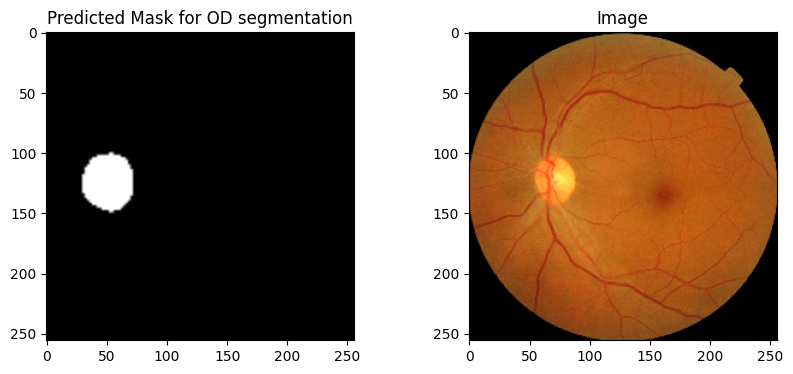

In [49]:
#define custom objects like loss function and evaluation metrics: accuracy, iou
custom_objects = {'accuracy': accuracy, 'iou':iou, 'loss': loss}

#load model from drive
my_od_model = load_model('/content/drive/My Drive/Models/od_model.hd5', custom_objects=custom_objects)

#Testing model

#reading image from drive folder
image_test = cv2.imread('/content/drive/My Drive/ORIGA DATASET/RIGA 200 Images/92.png')

#resizing image into 128 x 128 pixels and normalizing it
image_test = tf.image.resize(image_test, (128, 128))/122.5 - 1.0

#use loaded model to predict the od segmentation mask for the image-test
#thresholds the predicted mask and casts it to float datatype
mask_pred = (my_od_model.predict(tf.expand_dims(image_test, axis=0), verbose=0)[0] > 0.5).astype(float)
mask_pred = cv2.resize(mask_pred, (256, 256))

#create figre of two subplots
fig = plt.figure(figsize=(10, 4))
figaxis = fig.add_subplot(1, 2, 1)

#title of figure
figaxis.set_title('Predicted Mask for OD segmentation')

#convert mask to grayscale
mask_gray = color.gray2rgb(mask_pred)
optic_disk_mask = mask_gray

#display the predicted mask in first subplot
figaxis.imshow(mask_gray)

#diaply the original image in second subplot
Original_image = image[:, :, ::-1]
figaxis = fig.add_subplot(1, 2, 2)
figaxis.set_title('Image') #title
figaxis.imshow(image[:, :, ::-1])

**Optic Cup Segmentation**

In [4]:
#create masks
folder_path = "/content/drive/My Drive/ORIGA DATASET/RIGA 200 Images/"

for entry in os.listdir(folder_path):
    if(entry[-3:]=="tif"):
      #print(entry,"---",entry[-3:])
      imgPath = folder_path + entry
      #print(imgPath)

      img = cv2.imread(imgPath, cv2.IMREAD_GRAYSCALE )#the imread_unchanged flag so we can get the 4th channel

      shape = img.shape
      #print(shape)
      mask = np.zeros((shape), np.uint8)
      for i in range(len(img)):
          for j in range(len(img[i])):
              if img[i][j] == 255:
                  mask[i][j]= 255
      #resized_mask = cv2.resize(mask, (1371,1376))
      entry = entry.replace(".tif", "")
      cv2.imwrite(r"/content/drive/My Drive/ORIGA DATASET/MaskCups/mask"+entry + ".png",mask)

      #cv2.imwrite(r"C:\Users\Khadija\Desktop\new.png", img)


In [8]:
#getting the image and mask paths and setting batch size
ORICAPATH = "/content/drive/My Drive/ORIGA DATASET/RIGA 200 Images"
MASKPATH = "/content/drive/My Drive/ORIGA DATASET/MaskCups"
BATCH_SIZE = 4

In [6]:
def DoubleConvolution(x, fil):
    #convolve to 2d twice
    x = tf.keras.layers.Conv2D(fil,3,padding = "same",activation = "relu",kernel_initializer="he_normal")(x)
    x = tf.keras.layers.Conv2D(fil,3,padding = "same",activation = "relu",kernel_initializer = "he_normal")(x)
    return x

def Downsample(x, fil):#function to decrease spatial resolution
    f= DoubleConvolution(x, fil)
    param = tf.keras.layers.MaxPool2D(2)(f)
    param = tf.keras.layers.Dropout(0.33)(param)
    return f, param

def upsample(x, ConvolveF, filters): #function to increase resolution
    x = tf.keras.layers.Conv2DTranspose(filters, 3, 2, padding="same")(x)
    x = tf.keras.layers.concatenate([x, ConvolveF])
    x = tf.keras.layers.Dropout(0.33)(x)
    x = DoubleConvolution(x, filters)
    return x

def create_unet():
    # inputs
    inputs = tf.keras.layers.Input(shape=(128,128,3)) #creating layers with shape 128 by 128

    filter1,p1 = Downsample(inputs, 32) #downsampling by filter 32
    filter2, p2 = Downsample(p1, 64) #downsampling by filter 64
    filter3, p3 = Downsample(p2, 128) #downsampling by filter 128
    filter4, p4 = Downsample(p3, 256) #downsampling by filter 256
    bottleneck=DoubleConvolution(p4, 256) #performing the 2d conv


    up6 = upsample(bottleneck, filter4, 256) #now upsampling by size filter 256
    up7 = upsample(up6, filter3, 128) #by filter 128
    up8 = upsample(up7, filter2, 64) #by filter 64
    up9 = upsample(up8, filter1, 32) #by filter 32

    outputs =tf.keras.layers.Conv2D(1, 1, padding="same", activation = "sigmoid")(up9)
    unet_model =tf.keras.Model(inputs, outputs, name="U-Net")
    return unet_model



In [9]:
imgList, msk, fileNames = [], [], []
for imageName in os.listdir(ORICAPATH):
    if (imageName[-3:] == "png"):
      maskName = "mask"+ imageName
      img = cv2.imread(os.path.join(ORICAPATH, imageName)) #reading image from path
      img = cv2.resize(img,(256, 256)) #resizing the image
      print(os.path.join(MASKPATH, maskName))
      mask = cv2.imread(os.path.join(MASKPATH, maskName)) #reading mask
      mask = cv2.resize(mask,(256, 256)) #resizing the mask
      imgList.append(img) #
      msk.append(mask)
      fileNames.append(imageName)

/content/drive/My Drive/ORIGA DATASET/MaskCups/mask10.png
/content/drive/My Drive/ORIGA DATASET/MaskCups/mask16.png
/content/drive/My Drive/ORIGA DATASET/MaskCups/mask15.png
/content/drive/My Drive/ORIGA DATASET/MaskCups/mask1.png
/content/drive/My Drive/ORIGA DATASET/MaskCups/mask100.png
/content/drive/My Drive/ORIGA DATASET/MaskCups/mask17.png
/content/drive/My Drive/ORIGA DATASET/MaskCups/mask13.png
/content/drive/My Drive/ORIGA DATASET/MaskCups/mask12.png
/content/drive/My Drive/ORIGA DATASET/MaskCups/mask11.png
/content/drive/My Drive/ORIGA DATASET/MaskCups/mask14.png
/content/drive/My Drive/ORIGA DATASET/MaskCups/mask19.png
/content/drive/My Drive/ORIGA DATASET/MaskCups/mask24.png
/content/drive/My Drive/ORIGA DATASET/MaskCups/mask20.png
/content/drive/My Drive/ORIGA DATASET/MaskCups/mask25.png
/content/drive/My Drive/ORIGA DATASET/MaskCups/mask22.png
/content/drive/My Drive/ORIGA DATASET/MaskCups/mask2.png
/content/drive/My Drive/ORIGA DATASET/MaskCups/mask18.png
/content/drive/

In [10]:
def DiceCoefficient(TrueVal, PredictedVal): #function for dice coefficient
    TrueVal = tf.reshape(TrueVal, [-1])
    PredictedVal = tf.reshape(PredictedVal, [-1])
    intersection = tf.reduce_sum(TrueVal * PredictedVal)
    return ((2.*intersection) + 1e-6) / (tf.reduce_sum(TrueVal)+tf.reduce_sum(PredictedVal)+1e-6)

def dice_loss(TrueVal, PredVal): # loss function
    return -DiceCoefficient(TrueVal,PredictedVal=PredVal)

def log_dice_loss(TrueVal, PredVal):
    return -tf.math.log(DiceCoefficient(TrueVal, PredVal))



def interSectionOfUnion(TrueVal, PredVal, threshold=0.5):
    TrueVal = tf.reshape(TrueVal, [-1])
    TrueVal = tf.cast(TrueVal, tf.float32)
    PredVal = tf.cast(PredVal > threshold, tf.float32)
    PredVal = tf.reshape(PredVal, [-1])

    intersection = tf.reduce_sum(PredVal*TrueVal)
    union = tf.reduce_sum(tf.cast(PredVal+TrueVal > 0, tf.float32))

    return intersection/union

In [11]:
def augmentation_fn(image, mask, training=True):
    image, mask = image.copy(), mask.copy() #create copies of images

    if training == True:
        image = tf.image.random_brightness(image, 0.15)
        image = tf.image.random_hue(image, 0.15)
        rand = np.random.randint(0, 1000,(2,))
        if np.random.rand() < 0.5: #50 percent chance
            random_size = np.random.randint(210, 256) # get random size of image
            image = tf.image.stateless_random_crop(image, [random_size, random_size, 3], seed=rand) #randomly crop the image
            mask = tf.image.stateless_random_crop(mask, [random_size, random_size, 3], seed=rand) #randomly crop the mask

        if np.random.rand() < 0.5: # 50 perc chance
            image = tf.image.stateless_random_flip_up_down(image, rand) #flip image
            mask = tf.image.stateless_random_flip_up_down(mask, rand) #flip mask


    image = tf.image.resize(image,(128, 128))/122.5 - 1.0
    print(image.shape)
    mask = tf.cast(tf.image.resize(mask, (128, 128)) > 122.5, float)[:, :, :1]

    return image, mask



In [12]:
# Split train and test
mask = list(range(len(imgList)))
np.random.seed(0)
np.random.shuffle(mask)
n = int(0.8*len(mask))
imgT = [imgList[i] for i in mask[:n]]
mskT = [msk[i] for i in mask[:n]]
nameTrain = [fileNames[i] for i in mask[:n]]

imgTs = [imgList[i] for i in mask[n:]]
mskTs = [msk[i] for i in mask[n:]]
nameTest = [fileNames[i] for i in mask[n:]]

def data_generator(x, y, batch_size=BATCH_SIZE, training=True):
    data = len(x)

    i = 0
    while True:
        if i + batch_size > data:
            i = 0
            mask = np.arange(data)
            np.random.shuffle(mask)
            x = [x[j] for j in mask]
            y = [y[j] for j in mask]
        mX = x[i: i + batch_size]
        mY = y[i: i + batch_size]
        processed_data = [augmentation_fn(a, b, training) for a, b in zip(mX, mY)]
        mX = [item[0] for item in processed_data]
        mY = [item[1] for item in processed_data]
        mX = tf.concat([tf.expand_dims(_, axis=0) for _ in mX], axis=0)
        mY = tf.concat([tf.expand_dims(_, axis=0) for _ in mY], axis=0)
        i += batch_size
        yield mX, mY



In [13]:
model = create_unet()

model.summary()
model.compile(
     optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
     loss=log_dice_loss,
     metrics=[DiceCoefficient, interSectionOfUnion]
)

train_generator = data_generator(imgT, mskT, training=True)
validation_generator = data_generator(imgTs, mskTs, training=False)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)
history = model.fit(
     train_generator,
     epochs=50,
     validation_data=validation_generator,
     steps_per_epoch=len(imgT)//BATCH_SIZE,
     validation_steps=len(imgTs)//BATCH_SIZE,
     callbacks=[early_stopping]
)

Streaming output truncated to the last 5000 lines.
(128, 128, 3)
15/20 [=====================>........] - ETA: 10s - loss: 1.4567 - DiceCoefficient: 0.2852 - interSectionOfUnion: 0.2115(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
16/20 [=======================>......] - ETA: 8s - loss: 1.4388 - DiceCoefficient: 0.2867 - interSectionOfUnion: 0.2108 (128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
17/20 [========================>.....] - ETA: 6s - loss: 1.4065 - DiceCoefficient: 0.2940 - interSectionOfUnion: 0.2148(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
18/20 [==========================>...] - ETA: 4s - loss: 1.3935 - DiceCoefficient: 0.2949 - interSectionOfUnion: 0.2154(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
19/20 [===========================>..] - ETA: 2s - loss: 1.4554 - DiceCoefficient: 0.2834 - interSectionOfUnion: 0.2050(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
20/20 [==============================] - ETA: 0s - loss: 1

In [16]:
from tensorflow.keras.utils import get_custom_objects
get_custom_objects().update({"log_dice_loss": log_dice_loss})
get_custom_objects().update({"DiceCoefficient": DiceCoefficient})
get_custom_objects().update({"interSectionOfUnion": interSectionOfUnion})
import pickle
pickle.dump(model, open('/content/drive/My Drive/Models/model.pkl', 'wb'))

file_path = '/content/drive/My Drive/Models/model.pkl'
pickled_model = pickle.load(open(file_path, 'rb'))

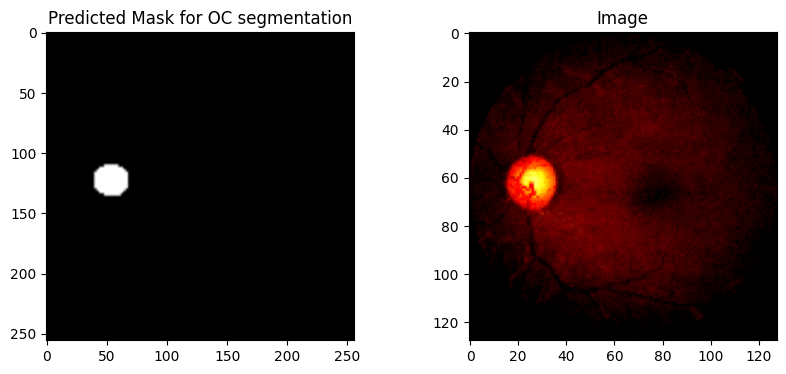

In [43]:
x_test = cv2.imread('/content/drive/My Drive/ORIGA DATASET/RIGA 200 Images/92.png')
x_test = tf.image.resize(x_test, (128, 128))/122.5 - 1.0

pred = (pickled_model.predict(tf.expand_dims(x_test, axis=0), verbose=0)[0] > 0.5).astype(float)
pred = cv2.resize(pred, (256, 256))

#create figre of two subplots
fig = plt.figure(figsize=(10, 4))
figaxis = fig.add_subplot(1, 2, 1)

#title of figure
figaxis.set_title('Predicted Mask for OC segmentation')

#convert mask to grayscale
optic_cup_mask = color.gray2rgb(pred)

#display the predicted mask in first subplot
figaxis.imshow(optic_cup_mask)

#display the original image in second subplot
figaxis = fig.add_subplot(1, 2, 2)
figaxis.set_title('Image') #title
figaxis.imshow(x_test[:, :, ::-1])

CDR Calculation

In [66]:
def find_CDR(Optic_Cup_image,Optic_Disc_image):
  #making varaibles to store the number of pixels ie area
  OD_pixels=0.0
  OC_pixels=0.0

  #Since the white region is indicating the optic cup and disc , and background is black so we are using 0 as the pixel values
  #If its white then sum thos pixels to find that area
  OD_pixels=np.sum(Optic_Disc_image!=0)
  OC_pixels=np.sum(Optic_Cup_image!=0)
  #displaying the pixels
  #print(OC_pixels,"****",OD_pixels)

  #Dividing the pixels to get CDR
  CDR=OC_pixels/OD_pixels
  print("CDR: ",CDR)

  return CDR

In [67]:
def Evaluation(Optic_Cup_image,Optic_Disc_image,Ground_truth_image):
  #declaring the varaibles to find the true negative , true positive etc
  tp = 0.0
  tn = 0.0
  fp = 0.0
  fn = 0.0

  #evaluation for optic disk
  #For the true positive, if the model said that true and its actually true then its tp
  tp=np.sum(np.logical_and((Optic_Disc_image!=0), (Ground_truth_image!=0)))
  #if the model is said its not true and actually its not true
  tn=np.sum(np.logical_and((Optic_Disc_image==0), (Ground_truth_image==0)))
  #calculating false positive
  fp=np.sum(np.logical_and((Optic_Disc_image!=0), (Ground_truth_image==0)))
  #Calculating false negative
  fn=np.sum(np.logical_and((Optic_Disc_image==0), (Ground_truth_image!=0)))

  #print(f'TP = {tp}, TN = {tn}, FP = {fp}, FN= {fn}')


  #precision
  precision=tp/(tp+fp)
  #accuracy
  accuracy=(tn+tp)/(tp+tn+fp+fn)
  #recall
  recall=tp/(tp+fn)
  #IoU
  IOU=tp/(tp+fp+fn)

  #Printing results
  print("Precision for OD: ",precision)
  print("Accuracy for OD: ",accuracy)
  print("Recall for OD: ", recall)
  print("IOU for OD: ", IOU)

  #evaluation of optic cup
  tp = 0.0
  tn = 0.0
  fp = 0.0
  fn = 0.0

  #evaluation for optic disk
  #For the true positive, if the model said that true and its actually true then its tp
  tp=np.sum(np.logical_and((Optic_Cup_image!=0), (Ground_truth_image==255)))
  #if the model is said its not true and actually its not true
  tn=np.sum(np.logical_and((Optic_Disc_image==0), (Ground_truth_image!=255)))
  #calculating false positive
  fp=np.sum(np.logical_and((Optic_Disc_image!=0), (Ground_truth_image!=255)))
  #Calculating false negative
  fn=np.sum(np.logical_and((Optic_Disc_image==0), (Ground_truth_image==255)))

  #print(f'TP = {tp}, TN = {tn}, FP = {fp}, FN= {fn}')


  #precision
  precision=tp/(tp+fp)
  #accuracy
  accuracy=(tn+tp)/(tp+tn+fp+fn)
  #recall
  recall=tp/(tp+fn)
  #IoU
  IOU=tp/(tp+fp+fn)

  #Printing results
  print("Precision for OC: ",precision)
  print("Accuracy for OC: ",accuracy)
  print("Recall for OC: ", recall)
  print("IOU for OC: ", IOU)

In [68]:
#Evulate results accoriding to the facts
def clinical_criteria(cdr):
  #its been noted if CDR is greater than 0.5 then the person have Glaucoma
  if cdr>0.5:
    print("High chances of having Glaucoma")
  #its been noted if CDR is less than 0.5 then the person does not have Glaucoma
  if cdr<0.5:
    print("No signs of having Glaucoma")

CDR:  0.39956331877729256
Precision for OD:  0.824235807860262
Accuracy for OD:  0.995086669921875
Recall for OD:  1.0
IOU for OD:  0.824235807860262
Precision for OC:  0.3198247535596933
Accuracy for OC:  0.981046848771555
Recall for OC:  1.0
IOU for OC:  0.3198247535596933
No signs of having Glaucoma


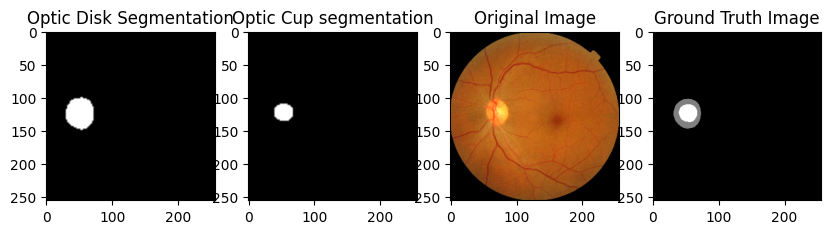

In [69]:
#image of optic cup predicted by the model
Optic_Cup_image=optic_cup_mask
#image of optic disk predicted by the model
Optic_Disc_image = optic_disk_mask

#reading grounud truth for test image
Ground_truth_image = cv2.resize(cv2.imread('/content/drive/My Drive/ORIGA DATASET/RIGA 200 Images/92.tif'), (256,256))

#create figre of two subplots
fig = plt.figure(figsize=(10, 4))
figaxis = fig.add_subplot(1, 4, 1)

#display optic disk segmentation
figaxis.set_title('Optic Disk Segmentation')
figaxis.imshow(Optic_Disc_image)

#display the optic cup segmentation
figaxis = fig.add_subplot(1, 4, 2)
figaxis.set_title('Optic Cup segmentation') #title
figaxis.imshow(Optic_Cup_image)

#display the original image
figaxis = fig.add_subplot(1, 4, 3)
figaxis.set_title('Original Image') #title
figaxis.imshow(Original_image)

#display the ground truth image
figaxis = fig.add_subplot(1, 4, 4)
figaxis.set_title('Ground Truth Image') #title
figaxis.imshow(Ground_truth_image)


#calculate CDR , calling function
cdr=find_CDR(Optic_Cup_image,Optic_Disc_image)
#Calling evualation to find the Accuracy and the other things
Evaluation(Optic_Cup_image,Optic_Disc_image,Ground_truth_image)
#calling function
clinical_criteria(cdr)
